In [3]:
import datetime
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
from cmap import Colormap

import numpy as np
import SimpleITK as sitk
from scipy.signal import find_peaks, peak_widths
from scipy.stats import ttest_ind
from skimage.exposure import histogram
from skimage.restoration import denoise_bilateral
from skimage.filters import gaussian, threshold_otsu, threshold_multiotsu
from skimage.morphology import disk, rectangle, ellipse
from skimage.morphology import binary_dilation, binary_erosion
from skimage.morphology import opening, remove_small_holes, remove_small_objects
from skimage.transform import pyramid_expand
from skimage.measure import label, regionprops
from sklearn.linear_model import LinearRegression

from utils import *
from hu_utils import *

# Statistics

## Load data from output/

In [5]:
all_maps = np.load('output\\DOD_KK_8539_DOD_8539_X-21-019-registered.npz')

low_pre_maps = all_maps.f.low_pre_maps
low_post_maps = all_maps.f.low_post_maps
high_pre_maps = all_maps.f.high_pre_maps
high_post_maps = all_maps.f.high_post_maps
brown_mask_maps = all_maps.f.brown_mask_maps
white_mask_maps = all_maps.f.white_mask_maps

<>:1: SyntaxWarning: invalid escape sequence '\D'
<>:1: SyntaxWarning: invalid escape sequence '\D'
C:\Users\BrancaLab\AppData\Local\Temp\ipykernel_3444\2139699423.py:1: SyntaxWarning: invalid escape sequence '\D'
  all_maps = np.load('output\DOD_KK_8539_DOD_8539_X-21-019-registered.npz')


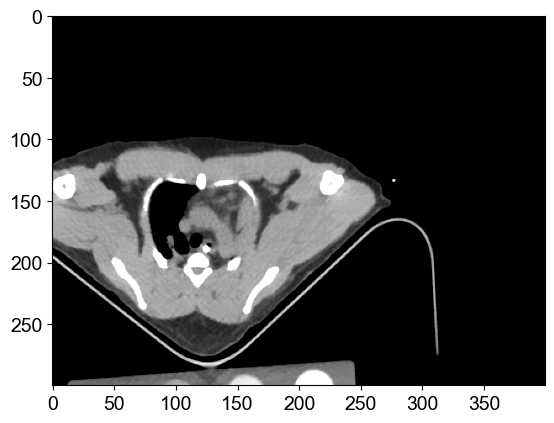

In [13]:
sample_idx = 250
sample_low_pre_map = low_pre_maps[sample_idx]
sample_low_post_map = low_post_maps[sample_idx]
sample_high_pre_map = high_pre_maps[sample_idx]
sample_high_post_map = high_post_maps[sample_idx]
sample_brown_mask_map = brown_mask_maps[sample_idx]
sample_white_mask_map = white_mask_maps[sample_idx]

plt.imshow(sample_low_post_map, cmap='gray', vmin=-200, vmax=200)
plt.show()

## Histogram

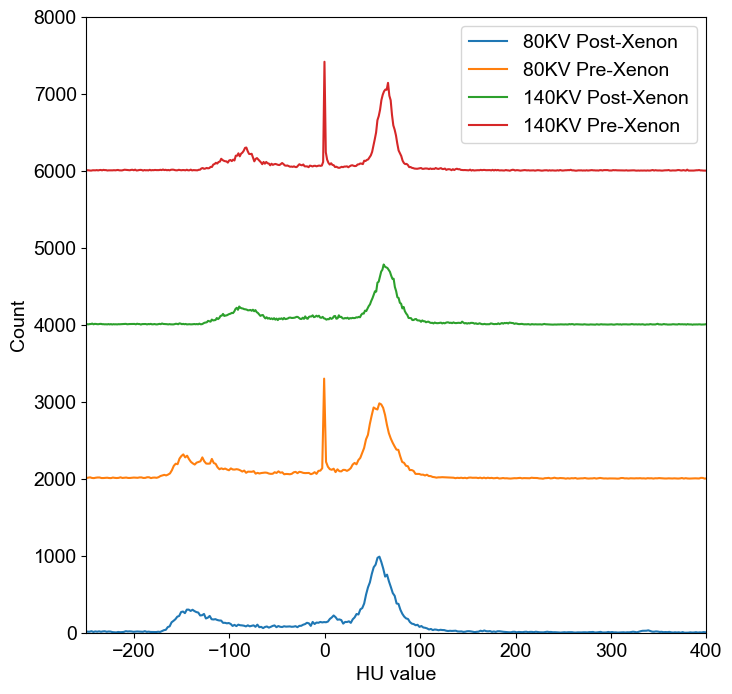

In [10]:
hist_low_post, bin_centers_low_post = histogram(sample_low_post_map, 2048)
hist_high_post, bin_centers_high_post = histogram(sample_high_post_map, 2048)
# remove the border that introduced by the registration
hist_low_pre, bin_centers_low_pre = histogram(sample_low_pre_map[sample_low_pre_map != 0], 2048)
hist_high_pre, bin_centers_high_pre = histogram(sample_high_pre_map[sample_high_pre_map != 0], 2048)

plt.figure(figsize=(8, 8))

plt.plot(bin_centers_low_post, hist_low_post, label='80KV Post-Xenon')
plt.plot(bin_centers_low_pre, hist_low_pre + 2000, label='80KV Pre-Xenon')
plt.plot(bin_centers_high_post, hist_high_post + 4000, label='140KV Post-Xenon')
plt.plot(bin_centers_high_pre, hist_high_pre + 6000, label='140KV Pre-Xenon')
plt.xlim(-250, 400)
plt.ylim(0, 8000)

plt.xlabel('HU value')
plt.ylabel('Count')
plt.legend()
plt.show()

# Image registration (optional, not implemented)

# Material decomposition

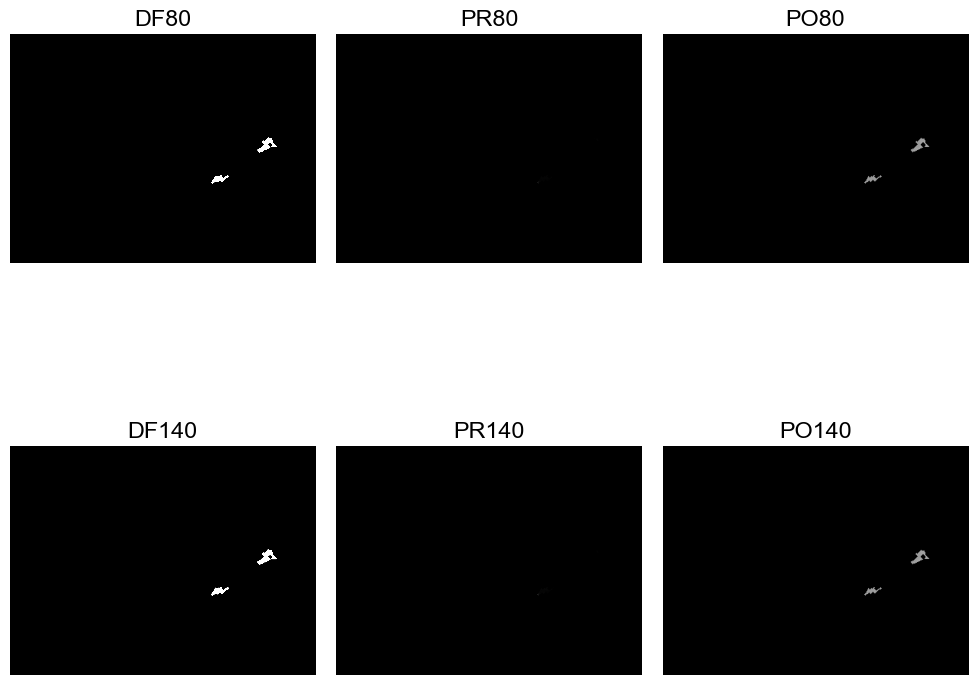

In [56]:
DF80_2D = np.where(sample_brown_mask_map, sample_low_post_map - sample_low_pre_map, 0)
PR80_2D = np.where(sample_brown_mask_map, sample_low_pre_map + 1000, 0)
PO80_2D = np.where(sample_brown_mask_map, sample_low_post_map + 1000, 0)
DF80 = DF80_2D.reshape(-1, 1)
PR80 = PR80_2D.reshape(-1, 1)
PO80 = PO80_2D.reshape(-1, 1)
DF80 = DF80[DF80 != 0][:, np.newaxis]
PR80 = PR80[PR80 != 0][:, np.newaxis]
PO80 = PO80[PO80 != 0][:, np.newaxis]

DF140_2D = np.where(sample_brown_mask_map, sample_high_post_map - sample_high_pre_map, 0)
PR140_2D = np.where(sample_brown_mask_map, sample_high_pre_map + 1000, 0)
PO140_2D = np.where(sample_brown_mask_map, sample_high_post_map + 1000, 0)
DF140 = DF140_2D.reshape(-1, 1)
PR140 = PR140_2D.reshape(-1, 1)
PO140 = PO140_2D.reshape(-1, 1)
DF140 = DF140[DF140 != 0][:, np.newaxis]
PR140 = PR140[PR140 != 0][:, np.newaxis]
PO140 = PO140[PO140 != 0][:, np.newaxis]

plt.figure(figsize=(10, 10))

plt.subplot(231)
plt.imshow(DF80_2D, cmap='gray', vmin=50, vmax=100)
plt.title('DF80')
plt.axis('off')

plt.subplot(232)
plt.imshow(PR80_2D, cmap='gray', vmin=0, vmax=1500)
plt.title('PR80')
plt.axis('off')

plt.subplot(233)
plt.imshow(PO80_2D, cmap='gray', vmin=0, vmax=1500)
plt.title('PO80')
plt.axis('off')

plt.subplot(234)
plt.imshow(DF140_2D, cmap='gray', vmin=0, vmax=100)
plt.title('DF140')
plt.axis('off')

plt.subplot(235)
plt.imshow(PR140_2D, cmap='gray', vmin=0, vmax=1500)
plt.title('PR140')
plt.axis('off')

plt.subplot(236)
plt.imshow(PO140_2D, cmap='gray', vmin=0, vmax=1500)
plt.title('PO140')
plt.axis('off')

plt.tight_layout()
plt.show()

In [57]:
reg_df = LinearRegression(fit_intercept=True).fit(DF80, DF140)
slope_df = reg_df.coef_.item()
intercept_df = reg_df.intercept_.item()
print(reg_df.score(DF80, DF140))

reg_pr = LinearRegression(fit_intercept=True).fit(PR80, PR140)
slope_pr = reg_pr.coef_.item()
intercept_pr = reg_pr.intercept_.item()
print(reg_pr.score(PR80, PR140))

0.8342785854743968
0.9474777862975303


Text(0, 0.5, 'DF(140)')

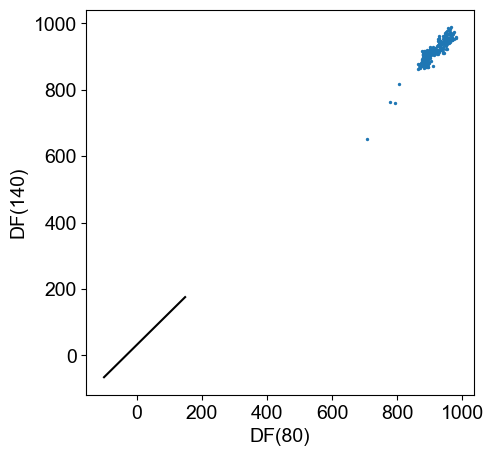

In [59]:
plt.figure(figsize=(5, 5))
plt.scatter(DF80, DF140, s=2)

reg_x_df = np.arange(-100, 150, 1)
reg_y_df = slope_df * reg_x_df + intercept_df
plt.plot(reg_x_df, reg_y_df, 'k')
plt.xlabel('DF(80)')
plt.ylabel('DF(140)')

# plt.xlim(-100, 150)
# plt.ylim(-100, 150)

Text(0, 0.5, 'PR(140)')

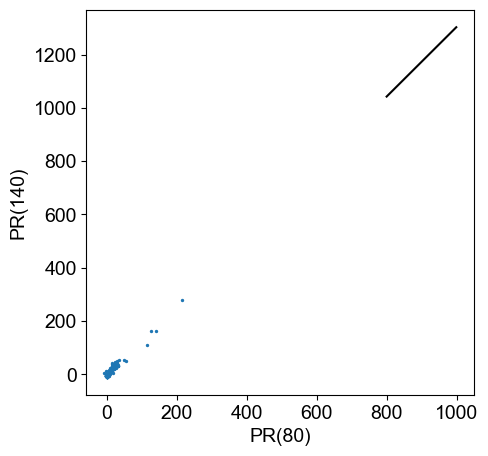

In [61]:
plt.figure(figsize=(5, 5))
plt.scatter(PR80, PR140, s=2)

reg_x_pr = np.arange(800, 1000, 1)

reg_y_pr = slope_pr * reg_x_pr + intercept_pr
plt.plot(reg_x_pr, reg_y_pr, 'k')

# plt.xlim(800, 1000)
# plt.ylim(850, 1100)

plt.xlabel('PR(80)')
plt.ylabel('PR(140)')

In [62]:
sf = slope_pr
sx = slope_df
cf = intercept_pr
cx = intercept_df


hu_f_80 = np.max(PR80)
hu_f_140 = (hu_f_80) * sf
hu_x_80 = np.max(DF80)
hu_x_140 = (hu_x_80) * sx

print(hu_f_140)

280.366583920101


In [63]:
A = np.array([[hu_f_80, hu_x_80],
              [hu_f_140, hu_x_140]])
print(A)
AINV = np.linalg.inv(A)
print(AINV)

[[214.39817111 981.41479288]
 [280.36658392 951.1119057 ]]
[[-0.01335095  0.01377632]
 [ 0.00393556 -0.00300955]]


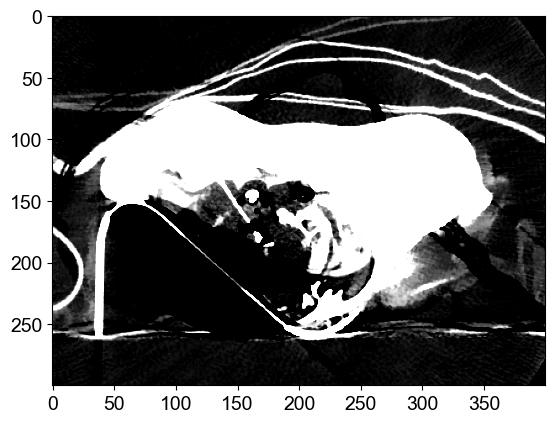

In [64]:
plt.imshow(sample_high_post_map - sample_high_pre_map, cmap='gray', vmin=0, vmax=100)

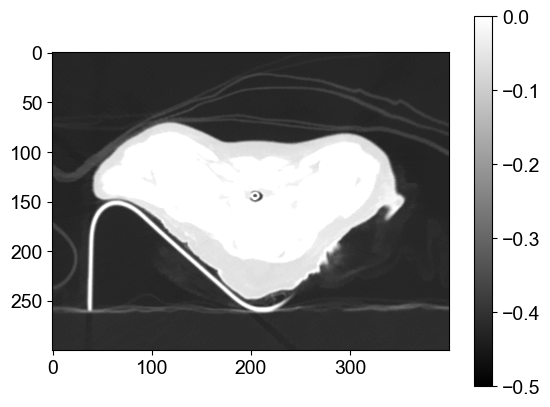

In [71]:
sample_flat = np.vstack((sample_low_post_map.reshape(1, -1), sample_low_post_map.reshape(1, -1)))
decomp_flat = np.matmul(AINV, sample_flat)
material1 = decomp_flat[0].reshape(sample_low_post_map.shape)
material2 = decomp_flat[1].reshape(sample_low_post_map.shape)

sample_brown_mask = sample_brown_mask_map
sample_white_mask = sample_white_mask_map

# plt.imshow(np.where(np.logical_or(sample_brown_mask, sample_white_mask), material1, np.nan), cmap='gray', vmin=-1, vmax=1)
plt.imshow(material1, cmap='gray', vmin=-0.5, vmax=0)
plt.colorbar()